<a href="https://colab.research.google.com/github/VicenteFran19/practica_py/blob/main/UPC_DMAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UPC - Data Mining & Data Analysis

Librerias a utilizar

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.cluster import KMeans

Funciones a utilizar

In [ ]:
def numerical_analysis(df,var,target):

    #resumiendo la tabla
    bd = df[[target,var]]
    bd = pd.DataFrame(bd)

    # asignar decil a toda la data
    bd['decile'] = 'P00'
    bd.loc[bd[var] >= bd[var].quantile(0.0), 'decile'] = 'D01'
    bd.loc[bd[var] >= bd[var].quantile(0.1), 'decile'] = 'D02'
    bd.loc[bd[var] >= bd[var].quantile(0.2), 'decile'] = 'D03'
    bd.loc[bd[var] >= bd[var].quantile(0.3), 'decile'] = 'D04'
    bd.loc[bd[var] >= bd[var].quantile(0.4), 'decile'] = 'D05'
    bd.loc[bd[var] >= bd[var].quantile(0.5), 'decile'] = 'D06'
    bd.loc[bd[var] >= bd[var].quantile(0.6), 'decile'] = 'D07'
    bd.loc[bd[var] >= bd[var].quantile(0.7), 'decile'] = 'D08'
    bd.loc[bd[var] >= bd[var].quantile(0.8), 'decile'] = 'D09'
    bd.loc[bd[var] >= bd[var].quantile(0.9), 'decile'] = 'D10'

    #creando data
    bd1 = bd[['decile',target]].groupby(['decile',target]).value_counts()
    bd1 = pd.DataFrame(bd1)
    bd1.reset_index(inplace=True)
    bd1 = bd1.pivot(index='decile',columns=target,values='count')
    bd1['non event'] = bd1[0]
    bd1['event'] = bd1[1]
    bd1 = bd1.drop(columns=[0,1])
    bd1['total'] = bd1['non event'] + bd1['event']
    bd1['total %'] = bd1['total'] / bd.shape[0]
    bd1['event rate'] = bd1['event'] / bd1['total']
    bd1.reset_index(inplace=True)
    bd1['non event %'] = bd1['non event'] / bd[target].value_counts()[0]
    bd1['event %'] = bd1['event'] / bd[target].value_counts()[1]
    bd1['WOE'] = np.log(bd1['event %'] / bd1['non event %'])
    bd1['IV'] = (bd1['event %'] - bd1['non event %']) * bd1['WOE']

    bd2 = bd[['decile',var]].groupby(['decile']).min()
    bd2.reset_index(inplace=True)
    bd2['min'] = bd2[var]
    bd2 = bd2.drop(columns=[var])

    bd3 = bd[['decile',var]].groupby(['decile']).max()
    bd3.reset_index(inplace=True)
    bd3['max'] = bd3[var]
    bd3 = bd3.drop(columns=[var])

    data = pd.merge(bd2, bd3, on='decile', how='left')
    data = pd.merge(data, bd1, on='decile', how='left')
    data['label'] = round(data['min'],4).apply(str).str.cat(round(data['max'],4).apply(str),sep=' - ')
    data['label'] = data['label'].str.cat(data['decile'].apply(str),sep=' : ')

    #agregando fila total
    data.loc[len(data.index)] = [ 'total',
                                 data['min'].min(),
                                 data['max'].max(),
                                 data['non event'].sum(),
                                 data['event'].sum(),
                                 data['total'].sum(),
                                 data['total %'].sum(),
                                 data['event'].sum() / data['total'].sum(),
                                 data['non event %'].sum(),
                                 data['event %'].sum(),
                                 np.nan,
                                 data['IV'].sum(),
                                 np.nan  ]

    display(data)

    #grafico resumen
    datafig = data[(data['decile']!='total')]
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=datafig['label'], y=datafig['event rate'], name='event rate', mode='lines'), secondary_y=True
        )

    fig.add_trace(
        go.Bar(x=datafig['label'], y=datafig['total'], name='total'), secondary_y=False
        )

    fig.update_xaxes(title_text='decile',tickangle=270)

    # Set y-axes titles
    fig.update_yaxes(title_text='total cases', secondary_y=False)
    fig.update_yaxes(title_text='event rate', secondary_y=True)
    fig.update_layout(height=600, width=900, showlegend=False, title_text=var)

    fig.show()

Ejercicio Regresion Logistica

In [ ]:
# Importando datos
data = pd.read_excel('/content/EjerciciosS06.xlsx',sheet_name='RNL01')
data.head(5)

,N_Lineas,Recibo_Prom,Antig_Laboral,Ingreso,Churn
0,2,29,2,1146,1
1,4,45,2,1158,0
2,1,29,2,1218,1
3,2,45,4,1272,0
4,2,59,3,1275,0


In [ ]:
fig = px.pie(data, names='Churn')
fig.show()

In [ ]:
X = data.drop(columns=['Churn'])
X = sm.add_constant(X)
y = data['Churn']

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Primera ejecución del modelo
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.335292
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4845
Model:                          Logit   Df Residuals:                     4840
Method:                           MLE   Df Model:                            4
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.05120
Time:                        00:43:12   Log-Likelihood:                -1624.5
converged:                       True   LL-Null:                       -1712.2
Covariance Type:            nonrobust   LLR p-value:                 7.517e-37
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6658      0.275      6.055      0.000       1.127       2.205
N_Lineas         -0.

In [ ]:
X = X.drop(columns=['N_Lineas','Recibo_Prom'])

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.335619
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4845
Model:                          Logit   Df Residuals:                     4842
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.05028
Time:                        00:43:25   Log-Likelihood:                -1626.1
converged:                       True   LL-Null:                       -1712.2
Covariance Type:            nonrobust   LLR p-value:                 4.124e-38
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5601      0.267      5.853      0.000       1.038       2.083
Antig_Laboral    -0.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X = X, y = y)

Yprob = logreg.predict_proba(X)
Yprob = [i[1] for i in Yprob]

Ypred = (logreg.predict_proba(X)[:, 1] >= 0.113).astype(int)

from sklearn.metrics import roc_auc_score
score = roc_auc_score(y, Yprob)

print(f"ROC AUC score of the model: {np.round(score, 5)}")

ROC AUC score of the model: 0.68848


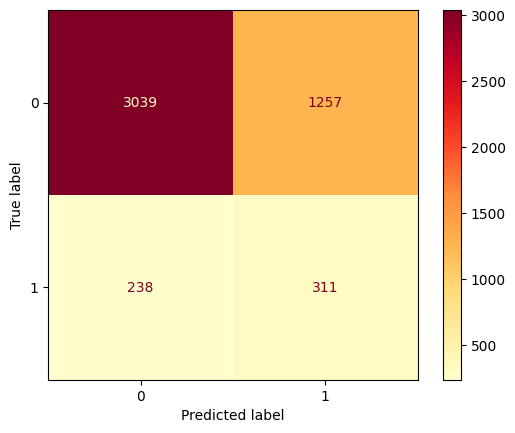

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y, Ypred, cmap ='YlOrRd')
plt.show()

In [ ]:
X['Y'] = y
X['Yprob'] = Yprob
X['Ypred'] = Ypred
X

,const,Antig_Laboral,Ingreso,Y,Yprob,Ypred
0,1.0,2,1146,1,0.453078,1
1,1.0,2,1158,0,0.449360,1
2,1.0,2,1218,1,0.430865,1
3,1.0,4,1272,0,0.346849,1
4,1.0,3,1275,0,0.379151,1
...,...,...,...,...,...,...
4840,1.0,5,2973,0,0.051931,0
4841,1.0,8,2976,0,0.034263,0
4842,1.0,5,2976,0,0.051746,0
4843,1.0,5,2979,0,0.051563,0


In [ ]:
numerical_analysis(X,'Yprob','Y')

,decile,min,max,non event,event,total,total %,event rate,non event %,event %,WOE,IV,label
0,D01,0.034263,0.061119,471,12,483,0.099690,0.024845,0.109637,0.021858,-1.612610,0.141553,0.0343 - 0.0611 : D01
1,D02,0.061171,0.068146,464,18,482,0.099484,0.037344,0.108007,0.032787,-1.192172,0.089676,0.0612 - 0.0681 : D02
2,D03,0.068204,0.074932,459,26,485,0.100103,0.053608,0.106844,0.047359,-0.813612,0.048398,0.0682 - 0.0749 : D03
3,D04,0.074995,0.081701,443,37,480,0.099071,0.077083,0.103119,0.067395,-0.425311,0.015194,0.075 - 0.0817 : D04
4,D05,0.081769,0.090248,441,47,488,0.100722,0.096311,0.102654,0.085610,-0.181556,0.003094,0.0818 - 0.0902 : D05
5,D06,0.090322,0.100769,442,47,489,0.100929,0.096115,0.102886,0.085610,-0.183821,0.003176,0.0903 - 0.1008 : D06
6,D07,0.100947,0.117823,418,63,481,0.099278,0.130977,0.097300,0.114754,0.164994,0.002880,0.1009 - 0.1178 : D07
7,D08,0.117917,0.146930,393,93,486,0.100310,0.191358,0.091480,0.169399,0.616131,0.048008,0.1179 - 0.1469 : D08
8,D09,0.147043,0.206200,384,101,485,0.100103,0.208247,0.089385,0.183971,0.721819,0.068274,0.147 - 0.2062 : D09
9,D10,0.206667,0.489534,381,105,486,0.100310,0.216049,0.088687,0.191257,0.768502,0.078825,0.2067 - 0.4895 : D10


Arbol de decision

Precisión del modelo: 0.90
Precisión promedio: 0.88
Desviación estándar: 0.00


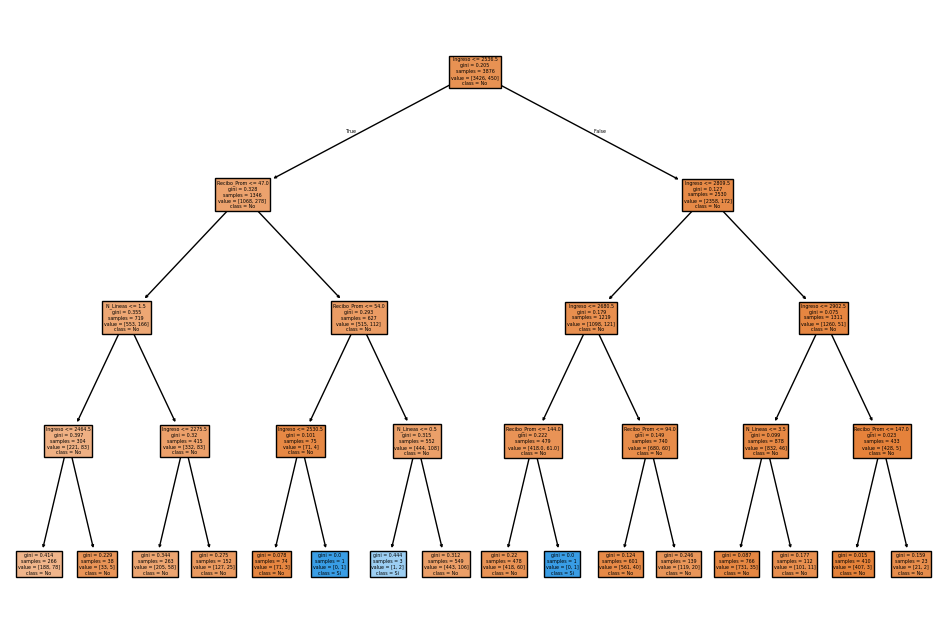

In [ ]:
X = data.drop(columns=['Churn'])
y = data['Churn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Crear el clasificador de árbol de decisión
#clf = DecisionTreeClassifier()
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular y mostrar la precisión del modelo
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {precision:.2f}')

# Realizar validación cruzada
scores = cross_val_score(clf, X, y, cv=5)

# Mostrar la precisión promedio y la desviación estándar
print(f'Precisión promedio: {scores.mean():.2f}')
print(f'Desviación estándar: {scores.std():.2f}')

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 8))
tree.plot_tree(clf,filled=True, feature_names=X_train.columns.tolist(), class_names=['No','Si'])
plt.show()

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
est_dt = DecisionTreeClassifier(max_depth=10)
est_dt.fit(X_train, y_train)
print('')
print('Decision Tree Classifier')
print("AUC Score : " , roc_auc_score(y_train,est_dt.predict_proba(X_train)[:,1]))


Decision Tree Classifier
AUC Score :  0.8859830057728482


In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
est_rf = RandomForestClassifier(n_estimators=50, max_depth=10)
est_rf.fit(X_train, y_train)
print('')
print('Random Forest Classifier')
print("AUC Score : " , roc_auc_score(y_train,est_rf.predict_proba(X_train)[:,1]))


Random Forest Classifier
AUC Score :  0.9588464033210093


In [ ]:
# XGBoost Classifier
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print('')
print('XGBoost Classifier')
print("AUC Score : " , roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))


XGBoost Classifier
AUC Score :  0.9410997600051889


In [ ]:
# LightGBM Classifier
import lightgbm as lgb
model = lgb.LGBMClassifier(verbose=-1)
model.fit(X_train, y_train)
print('')
print('LightGBM Classifier')
print("AUC Score : " , roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))


LightGBM Classifier
AUC Score :  0.9292287734319258


In [ ]:
# K-Means

In [ ]:
data = pd.read_excel('/content/EjerciciosS06.xlsx',sheet_name='CL01')
data

,Feature_1,Feature_2
0,2.698582,-0.672960
1,-0.128113,4.355952
2,2.509049,5.773146
3,-1.518276,3.444886
4,-0.072283,2.883769
...,...,...
495,10.303693,-4.378493
496,-0.730000,6.254563
497,-3.478708,2.257991
498,-2.081214,2.447245


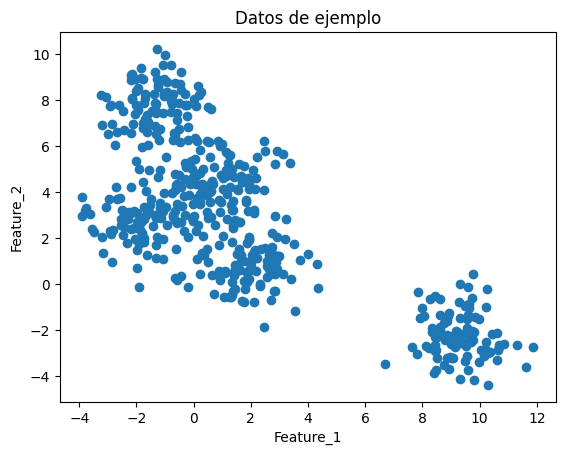

In [ ]:
# Suponiendo que las columnas relevantes para el clustering son 'X' y 'Y'
plt.scatter(data['Feature_1'], data['Feature_2'])
plt.title('Datos de ejemplo')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.show()

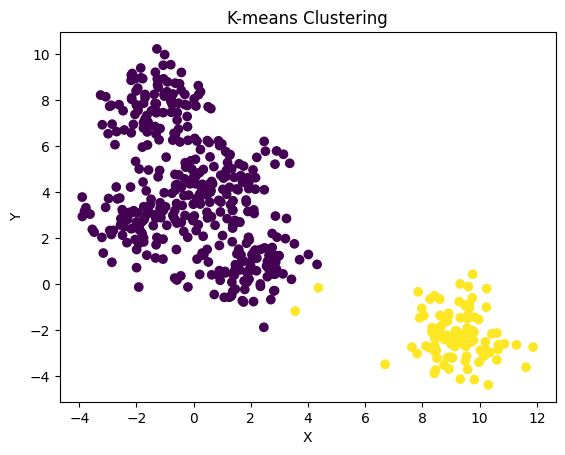

In [ ]:
from sklearn.cluster import KMeans

# Seleccionar las columnas para el clustering
X = data[['Feature_1', 'Feature_2']]

# Ajustar el modelo de K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Añadir las etiquetas de cluster al DataFrame
data['Cluster'] = kmeans.labels_

# Visualizar los clusters
plt.scatter(data['Feature_1'], data['Feature_2'], c=data['Cluster'], cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
